In [ ]:
import json
import os
from itertools import combinations
from math import sqrt
import subprocess

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit 

from models import TimesliceTransformer, OutcomeMLP

### Setup

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [153]:
hero2idx_path = "../data/hero_to_idx.json"
item2idx_path = "../data/item_to_idx.json"

with open(hero2idx_path, "r") as hero_file:
        hero_to_idx = json.load(hero_file)
with open(item2idx_path, "r") as item_file:
    item_to_idx = json.load(item_file)

max_seq_len = 123

In [154]:
def encode_timeslice(state, hero_to_idx, item_to_idx):
    """
    Encode a single timeslice state into 1-D representation: (hero_ids, item_ids, player_numeric, team_numeric)
    """
    hero_ids = []
    item_ids = []
    player_numeric = []
    player_num_keys = [
        "level","xp","networth","totalGold","currentGold","lifeState",
        "respawnSeconds","buybackCooldown","heroDamage","towerDamage",
        "damageTakenPostReduction","kills","deaths","assists","lastHits",
        "denies","teamfightParticipation","obsPlaced","senPlaced"
    ]

    for team in ("radiant", "dire"):
        for player in state[team]["players"]:
            hero_ids.append(hero_to_idx[str(player["heroId"])])
            inv_ids = []
            for slot in range(6):
                if slot < len(player["inventory"]):
                    item_name = player["inventory"][slot].get("id")
                    inv_ids.append(item_to_idx.get(item_name, item_to_idx["<PAD>"]))
                else:
                    inv_ids.append(item_to_idx["<PAD>"])
            item_ids.append(inv_ids)
            numeric_vals = [player[key] for key in player_num_keys]
            player_numeric.append(numeric_vals)

    team_numeric = []
    team_num_keys = [
        "totalCampsStacked","totalRunePickups","totalTowersKilled","totalRoshansKilled",
        "totalSmokesUsed","numWards","pdistMean","pdistMax","pdistStd",
        "centroidWardMean","hwMean","hwMin","hwMax"
    ]
    building_keys = state["radiant"]["buildings"].keys()

    for team in ("radiant", "dire"):
        buildings = [state[team]["buildings"][bk]["health"] for bk in building_keys]
        other = [state[team].get(k, 0) for k in team_num_keys]
        team_numeric.append(buildings + other)

    player_numeric = torch.tensor(player_numeric, dtype=torch.float32)
    team_numeric = torch.tensor(team_numeric, dtype=torch.float32)
    player_numeric = torch.log1p(player_numeric)
    team_numeric = torch.log1p(team_numeric)

    return hero_ids, item_ids, player_numeric, team_numeric

In [157]:
model = TimesliceTransformer(
    hero_vocab_size=len(hero_to_idx),
    item_vocab_size=len(item_to_idx),
    max_seq_len=max_seq_len
).to(device)
model.load_state_dict(torch.load('../weights/transformer_pretrained_10.pth', map_location=device))
model.eval()

mlp = OutcomeMLP(model_dim=model.input_proj.out_features, hidden_dim=128)
mlp.load_state_dict(torch.load('../weights/outcome_mlp_2.pth', map_location=device))
mlp.to(device).eval()

OutcomeMLP(
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (act): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

### Inference

In [158]:
def infer_win_curve(match_json_path, window_size=20):
    with open(match_json_path) as f:
        data = json.load(f)

    time_keys = list(data.keys())
    total = len(data)
    times = []
    probs = []

    for start in range(0, total - window_size):
        hero_w, item_w, pnum_w, tnum_w = [], [], [], []
        for offset in range(window_size):
            state = data[time_keys[start + offset]]
            h, it, pnum, tnum = encode_timeslice(state, hero_to_idx, item_to_idx)
            hero_w.append(h)
            item_w.append(it)
            pnum_w.append(pnum)
            tnum_w.append(tnum)

        hero_tensor = torch.tensor([hero_w], dtype=torch.long).to(device)
        item_tensor = torch.tensor([item_w], dtype=torch.long).to(device)
        pnum_tensor = torch.stack(pnum_w).unsqueeze(0).to(device)
        tnum_tensor = torch.stack(tnum_w).unsqueeze(0).to(device)

        with torch.no_grad():
            ctx = model.encode_sequence(hero_tensor, item_tensor, pnum_tensor, tnum_tensor)
            logit = mlp(ctx)
            prob = torch.sigmoid(logit).item()

        seconds = int(time_keys[start + window_size - 1])
        times.append(seconds / 60.0)
        probs.append(prob)

    return times, probs

def plot_win_curve(times, probs, title='Radiant Win Probability'):
    plt.figure(figsize=(10,4))
    plt.plot(times, probs, label=title)
    plt.axhline(0.5, color='gray', linestyle='--', label='50%')
    plt.xlim(0, max(times) + 1)
    plt.ylim(0, 1)
    plt.xlabel('Match Time (minutes)')
    plt.ylabel('Win Probability (Radiant)')
    plt.legend()
    plt.tight_layout()
    plt.show()

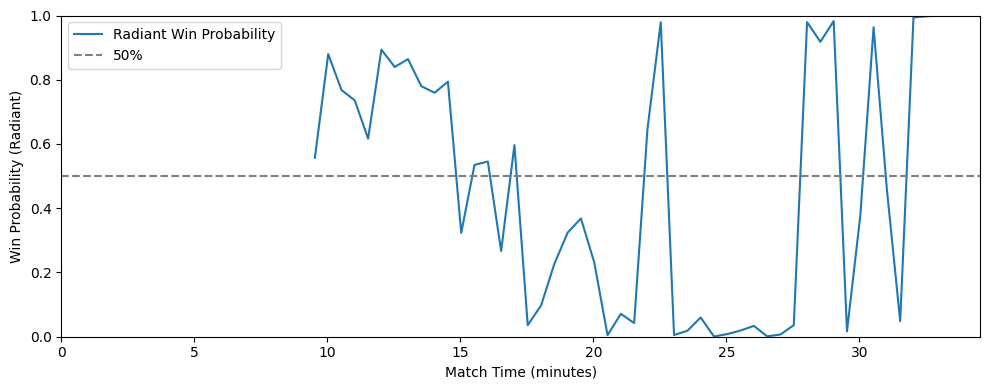

In [159]:
# https://uk.dotabuff.com/matches/7961497406
match_file = '../data/processed_replays/7961497406.json'
times, probs = infer_win_curve(match_file, window_size=20)
plot_win_curve(times, probs)

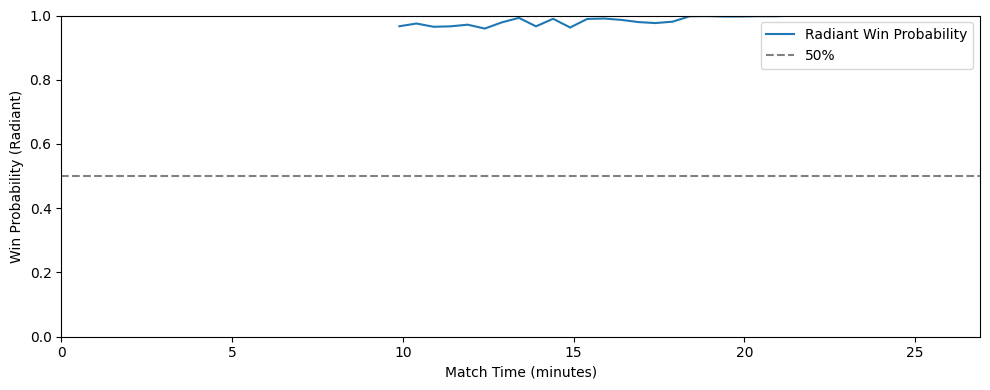

In [160]:
# https://uk.dotabuff.com/matches/7963873762
match_file = '../data/processed_replays/7963873762.json'
times, probs = infer_win_curve(match_file, window_size=20)
plot_win_curve(times, probs)

### Comparison

#### Helper functions

In [ ]:
def parse_replay(replay_path, output_path):
    command = ["java", "-jar", "../parser/replay-parser/target/replay-parser-1.0.0.jar", replay_path, output_path]
    try:
        subprocess.run(command, check=True)
        print(f"Replay parsed successfully! Output saved to {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while parsing replay: {e}")
        return
    return output_path

In [ ]:
def remove_fields(team_data: dict) -> dict:
    player_fields = [
        "heroId", "level", "xp", "networth", "totalGold", "currentGold",
        "lifeState", "respawnSeconds", "buybackCooldown",
        "heroDamage", "towerDamage", "damageTakenPostReduction",
        "kills", "deaths", "assists",
        "lastHits", "denies",
        "teamfightParticipation",
        "obsPlaced", "senPlaced",
        "x", "y"
    ]

    players = []
    for p in team_data.get("players", []):
        new_p = {}
        for key in player_fields:
            if key in p:
                new_p[key] = p[key]
        new_p["inventory"] = [{"id": item.get("id")} for item in p.get("inventory", [])]
        players.append(new_p)

    buildings = {
        name: {"health": b.get("health")}
        for name, b in team_data.get("buildings", {}).items()
    }

    output = {
        "players": players,
        "buildings": buildings,
        "observerWards": team_data.get("observerWards", []),
        "totalCampsStacked": team_data.get("totalCampsStacked", 0),
        "totalRunePickups": team_data.get("totalRunePickups", 0),
        "totalTowersKilled": team_data.get("totalTowersKilled", 0),
        "totalRoshansKilled": team_data.get("totalRoshansKilled", 0),
        "totalSmokesUsed": team_data.get("totalSmokesUsed", 0),
    }

    return output

In [164]:

MAP_DIAG = 256.0

def euclid(a, b):
    return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def calculate_fields(team_data: dict) -> dict:
    players = team_data.get("players", [])
    wards = team_data.get("observerWards", []) 
    for p in players:
        p['lifeState'] = 0 if p.get("lifeState", 0) == 0 else 1
        p["respawnSeconds"] = max(0, p.get("respawnSeconds", 0))

    alive_xy = np.array([(p["x"], p["y"]) for p in players if p["lifeState"] == 0], dtype=np.float32).reshape(-1, 2)
    ward_xy = np.array([(w["x"], w["y"]) for w in wards], dtype=np.float32).reshape(-1, 2)

    if len(alive_xy) >= 2:
        dists = [euclid(a, b) for a, b in combinations(alive_xy, 2)]
        team_pdist_mean = float(np.mean(dists))
        team_pdist_max = float(np.max(dists))
        team_pdist_std = float(np.std(dists, ddof=0))
    else:
        team_pdist_mean = team_pdist_max = team_pdist_std = 0.0

    if len(alive_xy) > 0:
        centroid = alive_xy.mean(axis=0)
    else:
        centroid = np.zeros(2, dtype=np.float32)

    if len(ward_xy):
        c2w = np.linalg.norm(ward_xy - centroid, axis=1)
        centroid_ward_mean = float(np.mean(c2w))
    else:
        centroid_ward_mean = 0.0

    if len(alive_xy) == 0 or len(ward_xy) == 0:
        hw_mean = hw_min = hw_max = MAP_DIAG
    else:
        D = np.linalg.norm(alive_xy[:, None, :] - ward_xy[None, :, :], axis=2)
        nearest_per_hero = D.min(axis=1)
        hw_mean = float(nearest_per_hero.mean())
        hw_min = float(nearest_per_hero.min())
        hw_max = float(nearest_per_hero.max())

    team_data.pop("observerWards", None)
    for p in players:
        p.pop("x", None)
        p.pop("y", None)

    team_data["numWards"] = len(wards)
    team_data["pdistMean"] = round(team_pdist_mean, 2)
    team_data["pdistMax"] = round(team_pdist_max, 2)
    team_data["pdistStd"] = round(team_pdist_std, 2)
    team_data["centroidWardMean"] = round(centroid_ward_mean, 2)
    team_data["hwMean"] = round(hw_mean, 2)
    team_data["hwMin"] = round(hw_min, 2)
    team_data["hwMax"] = round(hw_max, 2)

    return team_data

In [165]:
def process_slice(ts: dict):
    for team in ('radiant', 'dire'):
        team_data = ts[team]
        team_data = remove_fields(team_data)
        team_data = calculate_fields(team_data)
        ts[team] = team_data
    return ts

#### Process new replays

In [167]:
experiments_replays_dir = '../data/experiments/replays/'
parsed_replays_dir = '../data/experiments/parsed/'
processed_replays_dir = '../data/experiments/processed/'

os.makedirs(parsed_replays_dir, exist_ok=True)
os.makedirs(processed_replays_dir, exist_ok=True)

In [168]:
for replay_file in os.listdir(experiments_replays_dir):
    parsed_path = parse_replay(os.path.join(experiments_replays_dir, replay_file), os.path.join(parsed_replays_dir, replay_file[:-4] + '.json'))
    replay_data = json.load(open(parsed_path, 'r', encoding='utf-8'))
    for time in replay_data:
        ts = replay_data[time]
        replay_data[time] = process_slice(ts)
    with open(os.path.join(processed_replays_dir, replay_file[:-4] + '.json'), 'w', encoding='utf-8') as f:
        json.dump(replay_data, f, indent=2)

Replay parsed successfully! Output saved to ../data/experiments/parsed/8154891997.json
Replay parsed successfully! Output saved to ../data/experiments/parsed/8156671486.json


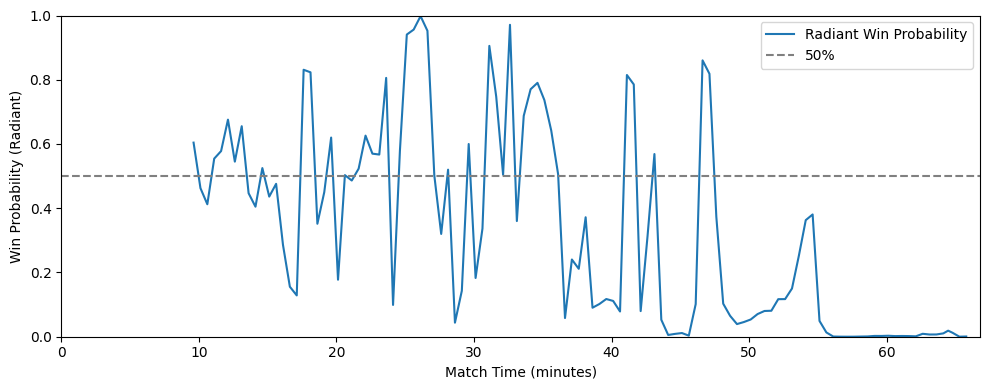

In [169]:
# https://uk.dotabuff.com/matches/8156671486
match_file = '../data/experiments/processed/8156671486.json'
times, probs = infer_win_curve(match_file, window_size=20)
plot_win_curve(times, probs)

In [ ]:
def temp_scale(p, tau, eps = 1e-6):
    p = np.clip(p, eps, 1.0 - eps)
    logit = np.log(p / (1.0 - p))
    p_scaled = expit(logit / tau)
    return p_scaled

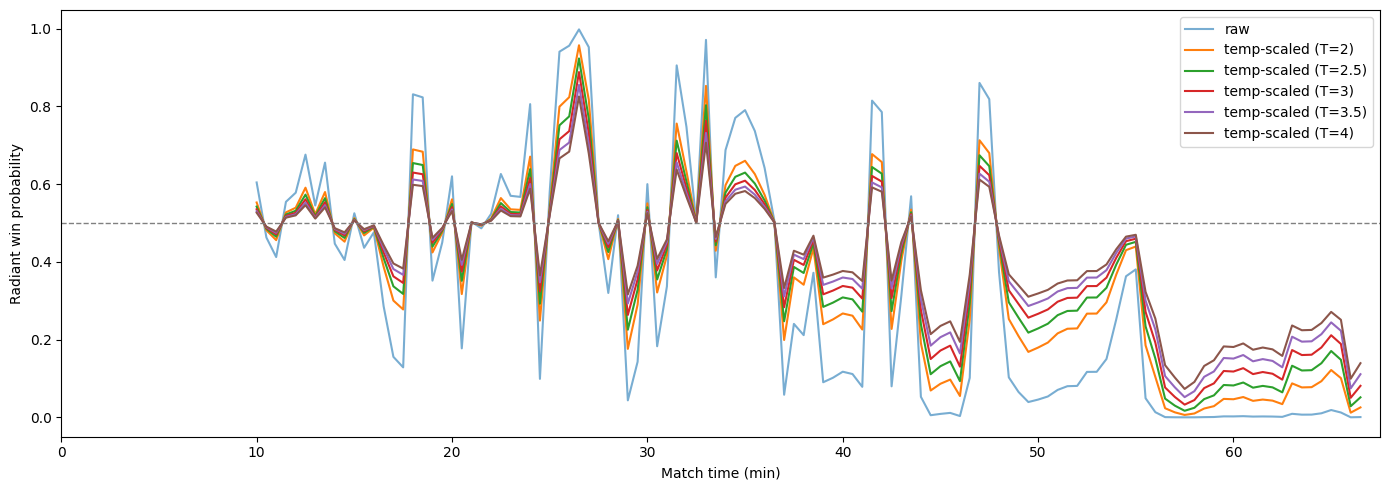

In [ ]:
p_raw = probs
p_tau2 = temp_scale(p_raw, tau=2)
p_tau2_5 = temp_scale(p_raw, tau=2.5)
p_tau3 = temp_scale(p_raw, tau=3)
p_tau3_5 = temp_scale(p_raw, tau=3.5)
p_tau4 = temp_scale(p_raw, tau=4)

t = 10 + np.arange(len(p_raw)) / 2
plt.figure(figsize=(14,5))
plt.plot(t, p_raw, label="raw", alpha=0.6)
plt.plot(t, p_tau2, label="temp-scaled (T=2)")
plt.plot(t, p_tau2_5, label="temp-scaled (T=2.5)")
plt.plot(t, p_tau3, label="temp-scaled (T=3)")
plt.plot(t, p_tau3_5, label="temp-scaled (T=3.5)")
plt.plot(t, p_tau4, label="temp-scaled (T=4)")
plt.xlim(0, max(t) + 1)
plt.axhline(0.5, ls="--", c="grey", lw=1)
plt.xlabel("Match time (min)")
plt.ylabel("Radiant win probability")
plt.legend(); plt.tight_layout(); plt.show()

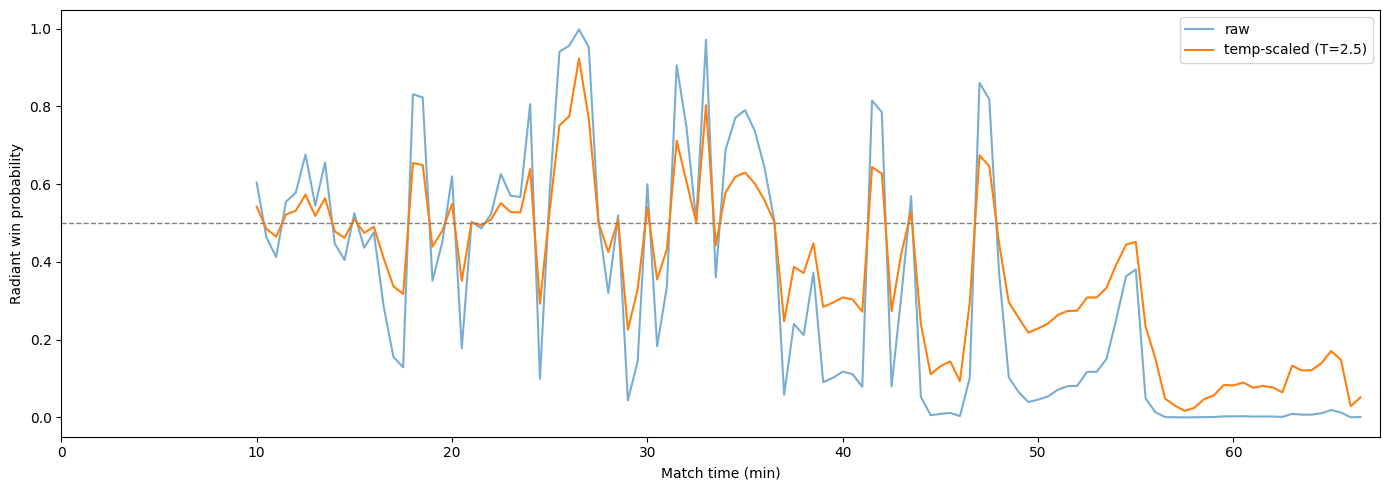

In [ ]:

t = 10 + np.arange(len(p_raw)) / 2
plt.figure(figsize=(14,5))
plt.plot(t, p_raw, label="raw", alpha=0.6)
plt.plot(t, p_tau2_5, label="temp-scaled (T=2.5)")
plt.xlim(0, max(t) + 1)
plt.axhline(0.5, ls="--", c="grey", lw=1)
plt.xlabel("Match time (min)")
plt.ylabel("Radiant win probability")
plt.legend(); plt.tight_layout(); plt.show()

In [174]:
def plot_calibrated_win_curve(times, probs):
    probs = temp_scale(probs, tau=2.5)
    plot_win_curve(times, probs)

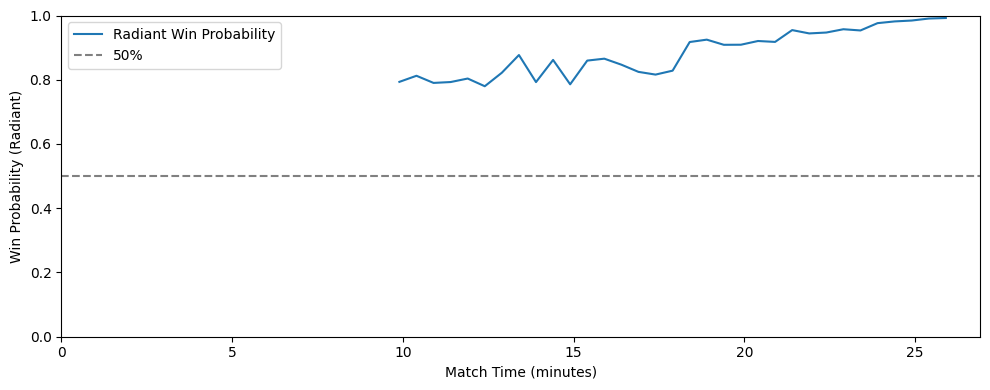

In [175]:
# https://uk.dotabuff.com/matches/7963873762
match_file = '../data/processed_replays/7963873762.json'
times, probs = infer_win_curve(match_file, window_size=20)
plot_calibrated_win_curve(times, probs)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29636\2953417833.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


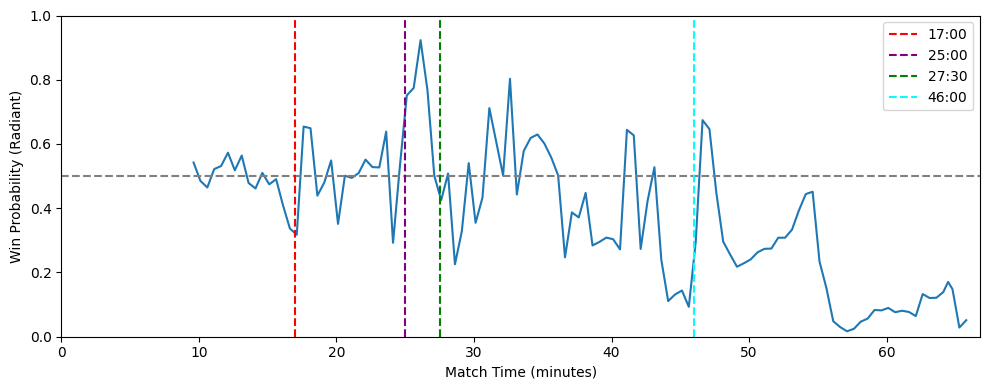

In [176]:
match_file = '../data/experiments/processed/8156671486.json'
times, probs = infer_win_curve(match_file, window_size=20)
probs = temp_scale(probs, tau=2.5)
plt.figure(figsize=(10,4))
plt.plot(times, probs)
plt.axhline(0.5, color='gray', linestyle='--')
plt.xlim(0, max(times) + 1)
plt.ylim(0, 1)
plt.xlabel('Match Time (minutes)')
plt.ylabel('Win Probability (Radiant)')
plt.legend()
plt.tight_layout()
plt.axvline(x=17, color='red', linestyle='--', label='17:00')
plt.axvline(x=25, color='purple', linestyle='--', label='25:00')
plt.axvline(x=27.5, color='green', linestyle='--', label='27:30')
plt.axvline(x=46, color='cyan', linestyle='--', label='46:00')
plt.legend()
plt.show()


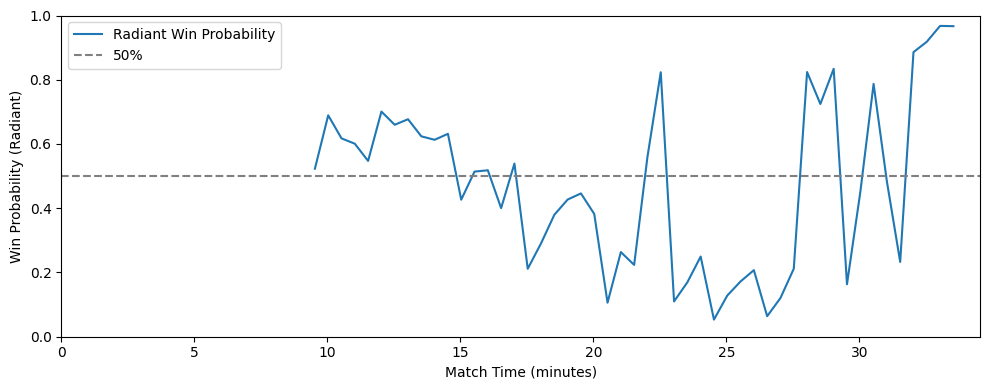

In [177]:
match_file = '../data/processed_replays/7961497406.json'
times, probs = infer_win_curve(match_file, window_size=20)
plot_calibrated_win_curve(times, probs)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29636\912543385.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


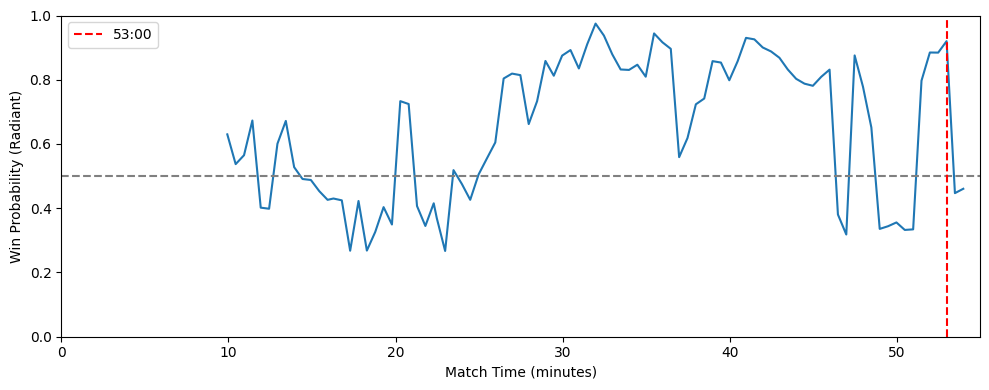

In [182]:
match_file = '../data/experiments/processed/8154891997.json'
times, probs = infer_win_curve(match_file, window_size=20)
probs = temp_scale(probs, tau=2.5)
plt.figure(figsize=(10,4))
plt.plot(times, probs)
plt.axhline(0.5, color='gray', linestyle='--')
plt.xlim(0, max(times) + 1)
plt.ylim(0, 1)
plt.xlabel('Match Time (minutes)')
plt.ylabel('Win Probability (Radiant)')
plt.legend()
plt.tight_layout()
plt.axvline(x=53, color='red', linestyle='--', label='53:00')
plt.legend()
plt.show()